# Setup

In [1]:
pip install shap

     |████████████████████████████████| 564 kB 27.7 MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from scipy import stats
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from datetime import datetime
import tensorflow as tf
import keras

from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

from numpy.random import seed
seed(2022)

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/Data Modelling/Stock Prices Prediction/train.csv')
#df = df[['date','retweets', 'likes', 'Software', 'Cloud',
#       'Work', 'Humor', 'Woman', 'Partnership', 'Community', 'Improvement',
#       'symbol', 'marketCap', 'peRatio', 'eps',
#       'sentiment','vol_diff_lead', 'change_lead']]
train

X_train = train.drop("change_lead", axis = 1)
y_train = train["change_lead"]

In [5]:
y_train

0       0
1       0
2       1
3       1
4       1
       ..
2476    1
2477    1
2478    1
2479    0
2480    1
Name: change_lead, Length: 2481, dtype: int64

In [6]:
test = pd.read_csv('/content/drive/MyDrive/Data Modelling/Stock Prices Prediction/test.csv')
#df = df[['date','retweets', 'likes', 'Software', 'Cloud',
#       'Work', 'Humor', 'Woman', 'Partnership', 'Community', 'Improvement',
#       'symbol', 'marketCap', 'peRatio', 'eps',
#       'sentiment','vol_diff_lead', 'change_lead']]

X_test = test.drop("change_lead", axis = 1)
y_test = test["change_lead"]
y_test

0      1
1      1
2      1
3      1
4      1
      ..
271    0
272    1
273    1
274    1
275    0
Name: change_lead, Length: 276, dtype: int64

In [7]:
# Seed value
seed_value= 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [8]:
X_train

,retweets,likes,Software,Cloud,Work,Humor,Woman,Partnership,Community,Improvement,eps,sentiment,prev_day_change
0,0.000000,0.000003,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.000,1.000000,0.5,1
1,0.000027,0.000010,0.000000,0.0,0.000000,0.0,0.111111,0.000000,0.0,0.000,0.022573,0.5,1
2,0.000000,0.000001,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,1.000000,1.0,0
3,0.000018,0.000007,0.000000,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.000,0.022573,1.0,0
4,0.000015,0.000007,0.000000,0.0,0.000000,0.1,0.000000,0.000000,0.0,0.000,0.022573,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,0.001812,0.006338,0.000000,0.0,0.000000,0.0,0.000000,0.285714,0.0,0.000,0.000000,1.0,0
2477,0.000207,0.000253,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.555488,0.5,1
2478,0.003072,0.006149,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.000,0.000000,1.0,1
2479,0.000991,0.002122,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.125,1.000000,0.5,1


# Helper Function

In [9]:
agg_accuracy_score_dict = {}
agg_f1_score_dict={}
agg_roc_auc_dict={}

train_accuracy_score_dict = {}
train_f1_score_dict={}
train_roc_auc_dict={}

val_accuracy_score_dict = {}
val_f1_score_dict={}
val_roc_auc_dict={}

test_accuracy_score_dict = {}
test_f1_score_dict={}
test_roc_auc_dict={}

def evaluation(true, pred, title):
    print("================== Evaluation on {} ==================".format(title))
    # accuracy 
    acc = accuracy_score(true, pred)
    print("accuracy: {}\n".format(acc))
    agg_accuracy_score_dict[title] = acc
    # f1 score
    print("classification report: \n{}\n".format(classification_report(true, pred)))
    print("F1 score: \n{}\n".format(metrics.f1_score(true, pred)))
    f1 = f1_score(true, pred)
    agg_f1_score_dict[title] = f1
    # confusion matrix
    print("Confusion matrix: \n{}\n".format(confusion_matrix(true, pred)))
    # roc auc result
    fpr, tpr, thresholds = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC: {}\n".format(roc_auc))
    agg_roc_auc_dict[title] = roc_auc
    print("================== End of Evaluation on {} ==================".format(title))
    
    if "train dataset" in title:
        train_accuracy_score_dict[title] = acc
        train_f1_score_dict[title] = f1
        train_roc_auc_dict[title] = roc_auc
    elif "test dataset" in title:
        test_accuracy_score_dict[title] = acc
        test_f1_score_dict[title] = f1
        test_roc_auc_dict[title] = roc_auc
    else:
        val_accuracy_score_dict[title] = acc
        val_f1_score_dict[title] = f1
        val_roc_auc_dict[title] = roc_auc

# Logistic Regression



#### Codes



##### Default



In [10]:
lr = LogisticRegression(random_state=2022).fit(X_train, y_train)

In [11]:
# predicting training dataset
y_train_lr_predict = lr.predict(X_train)
evaluation(y_train, y_train_lr_predict, "Default logistic regression on train dataset")

================== Evaluation on Default logistic regression on train dataset ==================
accuracy: 0.535671100362757

classification report: 
              precision    recall  f1-score   support

           0       0.52      0.36      0.43      1193
           1       0.54      0.69      0.61      1288

    accuracy                           0.54      2481
   macro avg       0.53      0.53      0.52      2481
weighted avg       0.53      0.54      0.52      2481


F1 score: 
0.6084296397008837

Confusion matrix: 
[[434 759]
 [393 895]]

ROC AUC: 0.5293322721048768

================== End of Evaluation on Default logistic regression on train dataset ==================


In [12]:
# predicting test dataset
y_test_lr_predict = lr.predict(X_test)
evaluation(y_test, y_test_lr_predict, "Default logistic regression on test dataset")

================== Evaluation on Default logistic regression on test dataset ==================
accuracy: 0.5036231884057971

classification report: 
              precision    recall  f1-score   support

           0       0.58      0.26      0.36       147
           1       0.48      0.78      0.60       129

    accuracy                           0.50       276
   macro avg       0.53      0.52      0.48       276
weighted avg       0.53      0.50      0.47       276


F1 score: 
0.5958702064896755

Confusion matrix: 
[[ 38 109]
 [ 28 101]]

ROC AUC: 0.5207245688973263

================== End of Evaluation on Default logistic regression on test dataset ==================


##### Tuning






###### Random



In [13]:
lr = LogisticRegression(random_state=2022)
parameters = {"C":uniform(), "penalty":["l2"], "solver":["newton-cg", "sag", "saga", "lbfgs"]}
tune_lr_model = RandomizedSearchCV(lr, parameters, random_state=2022, cv = 3)
searched_lr_model = tune_lr_model.fit(X_train, y_train)

In [14]:
searched_lr_model.best_params_ 

{'C': 0.7211349291646855, 'penalty': 'l2', 'solver': 'newton-cg'}

In [15]:
y_train_lr_tuned_predict = searched_lr_model.predict(X_train)
evaluation(y_train, y_train_lr_tuned_predict, "Tuned logistic regression on train dataset")

================== Evaluation on Tuned logistic regression on train dataset ==================
accuracy: 0.5352680370818218

classification report: 
              precision    recall  f1-score   support

           0       0.52      0.35      0.42      1193
           1       0.54      0.70      0.61      1288

    accuracy                           0.54      2481
   macro avg       0.53      0.53      0.52      2481
weighted avg       0.53      0.54      0.52      2481


F1 score: 
0.61139197842939

Confusion matrix: 
[[421 772]
 [381 907]]

ROC AUC: 0.528542207910534

================== End of Evaluation on Tuned logistic regression on train dataset ==================


In [16]:
y_test_lr_tuned_predict = searched_lr_model.predict(X_test)
evaluation(y_test, y_test_lr_tuned_predict, "Tuned logistic regression on test dataset")

================== Evaluation on Tuned logistic regression on test dataset ==================
accuracy: 0.4927536231884058

classification report: 
              precision    recall  f1-score   support

           0       0.55      0.24      0.34       147
           1       0.47      0.78      0.59       129

    accuracy                           0.49       276
   macro avg       0.51      0.51      0.46       276
weighted avg       0.52      0.49      0.46       276


F1 score: 
0.5882352941176471

Confusion matrix: 
[[ 36 111]
 [ 29 100]]

ROC AUC: 0.510045878816643

================== End of Evaluation on Tuned logistic regression on test dataset ==================


###### Grid Search



In [17]:
# grid search 
lr = LogisticRegression(random_state=2022)
parameters = {"C":[0.7,2,3,4,5,6], "penalty":["l2", "none"], "solver":["newton-cg", "sag", "saga", "lbfgs"], "max_iter":[300,500]}
tune_lr_model = GridSearchCV(lr, parameters, cv = 3)
searched_lr_model = tune_lr_model.fit(X_train, y_train)

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
The max_iter was reached which means the coef_ did not converge
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ig

In [18]:
searched_lr_model.best_params_ 

{'C': 5, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}

In [19]:
y_test_lr_tuned_predict = searched_lr_model.predict(X_test)
evaluation(y_test, y_test_lr_tuned_predict, "Tuned logistic regression on test dataset")

================== Evaluation on Tuned logistic regression on test dataset ==================
accuracy: 0.5108695652173914

classification report: 
              precision    recall  f1-score   support

           0       0.58      0.31      0.40       147
           1       0.48      0.74      0.59       129

    accuracy                           0.51       276
   macro avg       0.53      0.53      0.49       276
weighted avg       0.53      0.51      0.49       276


F1 score: 
0.5871559633027523

Confusion matrix: 
[[ 45 102]
 [ 33  96]]

ROC AUC: 0.5251542477456099

================== End of Evaluation on Tuned logistic regression on test dataset ==================


# Evaluation

In [20]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(searched_lr_model.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 277it [00:18,  8.08it/s]


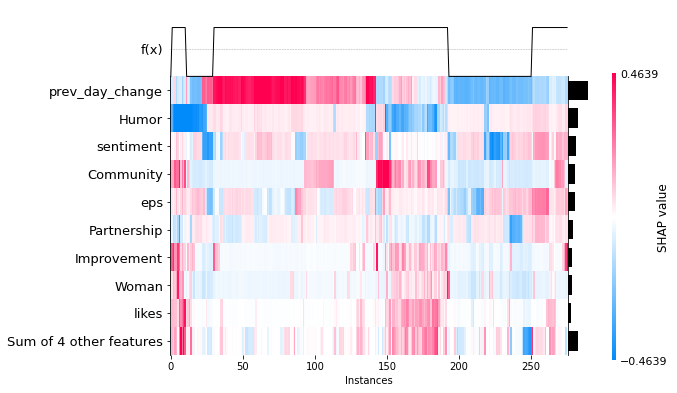

In [21]:
shap.plots.heatmap(shap_values)